In [1]:
# import modules
import os
import anndata as ad
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy.plot import gseaplot
import seaborn as sns
import matplotlib.pyplot as plt
import re

2023-08-02 20:20:41.871440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
# set working directory
os.chdir('/Volumes/Passport/CSDB/brain_scRNAseq/')

In [3]:
# load in data
adata = sc.read_h5ad('all_internship/data/processed/annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 37581 × 4000
    obs: 'Sample', 'condition', 'filtered', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'condition_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'condition_density_params', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_expr'
    obsp: 'connectivities', 'distances'

In [117]:
# load in raw data from raw slot
raw = adata.raw.to_adata()
raw

AnnData object with n_obs × n_vars = 37581 × 15872
    obs: 'Sample', 'condition', 'filtered', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'condition_density', '_scvi_raw_norm_scaling'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'condition_density_params', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [138]:
# extract TEs and subset data to TEs
rownames = raw.var_names
TEs = [TE for TE in rownames if (TE.endswith('LTR') or TE.endswith('LINE'))]
subset_adata = raw[:, TEs]
subset_adata

View of AnnData object with n_obs × n_vars = 37581 × 723
    obs: 'Sample', 'condition', 'filtered', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'condition_density', '_scvi_raw_norm_scaling'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'condition_density_params', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [140]:
# set base on as None (otherwise gives error)
subset_adata.uns['log1p']["base"] = None

ranking genes
    finished (0:00:10)


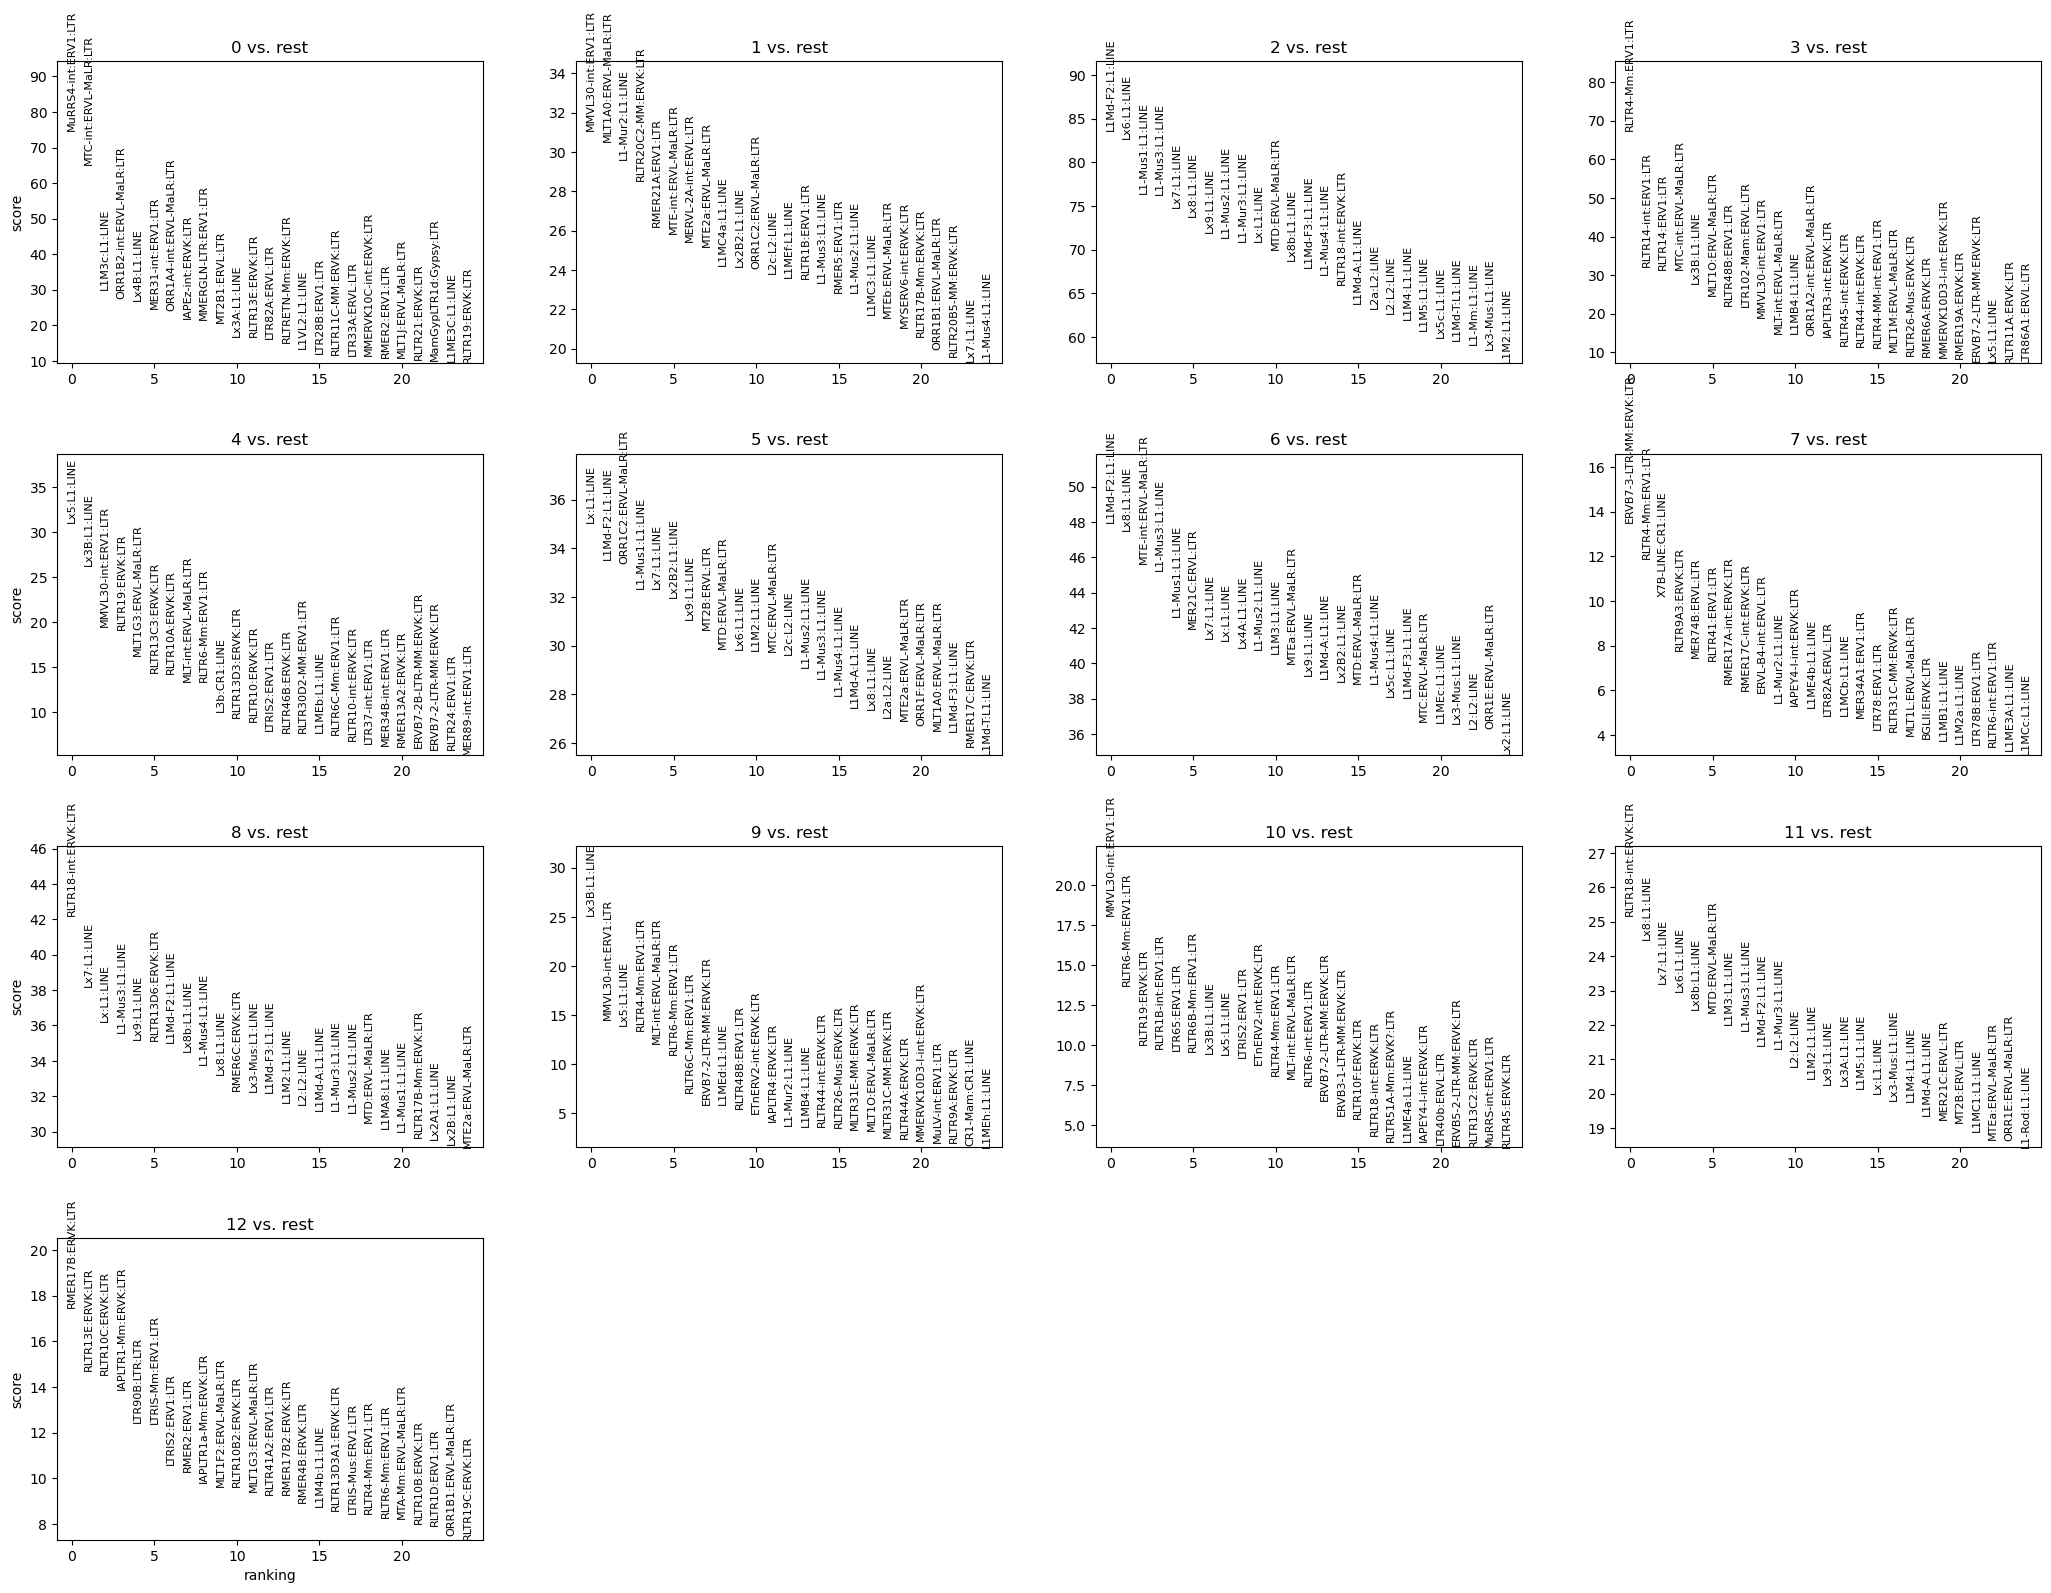

In [142]:
# calculate marker genes
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(subset_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(subset_adata, n_genes=25, sharey=False)

In [145]:
# extract marker genes
TE_markers = sc.get.rank_genes_groups_df(subset_adata, None)

In [149]:
# only. keep markers that are signficant and with logfolchange greater than 0.5
TE_markers = TE_markers[(TE_markers.pvals_adj < 0.05) & (TE_markers.logfoldchanges > .5)]

In [154]:
TE_markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,MuRRS4-int:ERV1:LTR,74.672859,2.482459,0.000000e+00,0.000000e+00
1,0,MTC-int:ERVL-MaLR:LTR,65.013840,1.200034,0.000000e+00,0.000000e+00
2,0,L1M3c:L1:LINE,29.923168,2.169775,9.832692e-197,9.873661e-196
3,0,ORR1B2-int:ERVL-MaLR:LTR,27.320127,0.779067,2.446146e-164,1.943477e-163
4,0,Lx4B:L1:LINE,26.810173,0.641413,2.459067e-158,1.851985e-157
...,...,...,...,...,...,...
8825,12,CR1-Mam:CR1:LINE,2.643132,1.285629,8.214309e-03,2.762300e-02
8826,12,RLTR20B1:ERVK:LTR,2.617964,1.068842,8.845623e-03,2.960827e-02
8829,12,RLTR49:ERVK:LTR,2.586698,0.732914,9.690059e-03,3.199047e-02
8837,12,RLTR6B-Mm:ERV1:LTR,2.476803,0.820522,1.325651e-02,4.222228e-02


In [ ]:
TE_markers[TE_markers['group'] == '0'][:10]

In [ ]:
TE_markers[TE_markers['group'] == '8'][:10]

In [ ]:
TE_markers[TE_markers['group'] == '3'][:10]

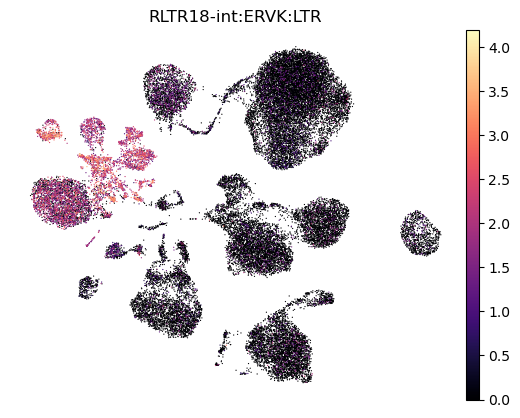

In [284]:
sc.pl.umap(adata, color = 'RLTR18-int:ERVK:LTR', frameon = False, cmap = 'magma')

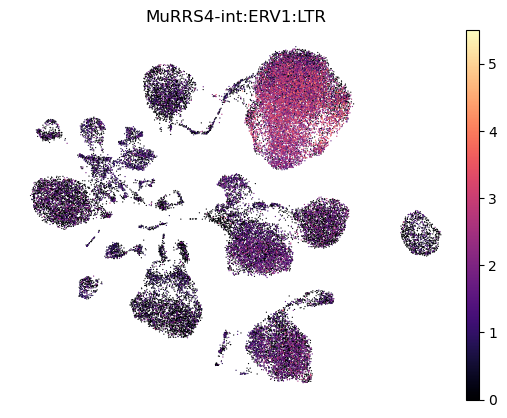

In [320]:
sc.pl.umap(adata, color = 'MuRRS4-int:ERV1:LTR', frameon = False, cmap = 'magma', vmax = 5.5, save = '_LTR_oligodendrocytes.png',)

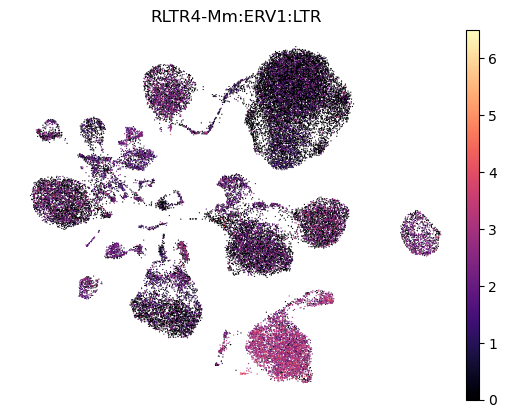

In [322]:
sc.pl.umap(adata, color = 'RLTR4-Mm:ERV1:LTR', frameon = False, cmap = 'magma', vmax = 6.5, save =  '_LTR_microglia&macrophages.png')